# Flight segments from Twin-Otter flights

In [1]:
%load_ext lab_black

In [2]:
from intake import open_catalog
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

import twinotter.plots
from twinotter.external.eurec4a import add_halo_circle
import twinotter
import worldview_dl
from tqdm.auto import tqdm
from pathlib import Path
import pytz
import PIL
import matplotlib.ticker as mticker
import numpy as np
import yaml
import pprint
import xarray as xr
import seaborn.objects as so
import pandas as pd

In [3]:
TO_CAT_URL = "https://raw.githubusercontent.com/leifdenby/eurec4a-intake/twinotter-masin/catalog.yml"

In [17]:
_cache = {}


def get_navdata_TO(flight_id, raw_data=False):
    """
    :param nav_data: flight id
    """
    import xarray as xr
    from intake import open_catalog
    import re

    match = re.match("TO-(\d+)", flight_id)
    if match is None:
        raise Exception(f"Malformed flight id {flight_id}")
    flight_number = int(match.groups()[0])

    catalog = open_catalog(TO_CAT_URL)

    if flight_number not in _cache:
        ds = catalog.TO.MASIN[f"TO{flight_number}_1Hz"].to_dask()
        ds = ds.rename(dict(Time="time"))
        _cache[flight_number] = ds
    else:
        ds = _cache[flight_number]

    if raw_data:
        return ds

    return xr.Dataset(
        {
            "time": ds.time,
            "lat": ds.LAT_OXTS,
            "lon": ds.LON_OXTS,
            "alt": ds.ALT_OXTS,
            "roll": ds.ROLL_OXTS,
            "pitch": ds.PTCH_OXTS,
            "heading": ds.HDG_OXTS,
        }
    )

# Checking MASIN altitude measurements

Text(0.5, 1.0, 'TO-333')

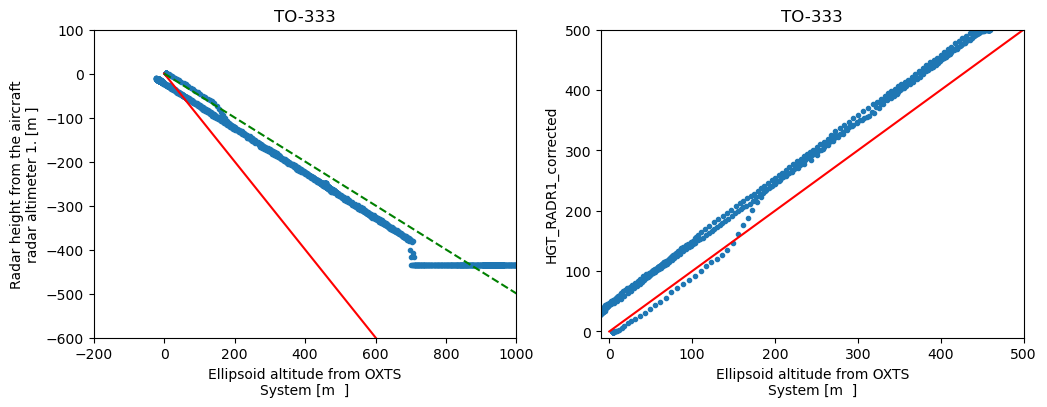

In [101]:
flight_id = "TO-333"
ds = get_navdata_TO(flight_id, raw_data=True)


fig, axes = plt.subplots(figsize=(12, 4), ncols=2)

ds["HGT_RADR1_corrected"] = -2.0 * ds.HGT_RADR1

ax = axes[0]
xr.plot.scatter(ds, "ALT_OXTS", "HGT_RADR1", marker=".", ax=ax)
ax.set_xlim(-200, 1000)
ax.set_ylim(-600, 100)
x = np.linspace(0, 1000, 100)
ax.plot(x, -x, color="red")
ax.plot(x, -0.5 * x, color="green", linestyle="--")
ax.set_title(flight_id)

ax = axes[1]
xr.plot.scatter(ds, "ALT_OXTS", "HGT_RADR1_corrected", marker=".", ax=ax)
ax.set_xlim(-10, 500)
ax.set_ylim(-10, 500)
x = np.linspace(0, 1000, 100)
ax.plot(x, x, color="red")
ax.set_title(flight_id)

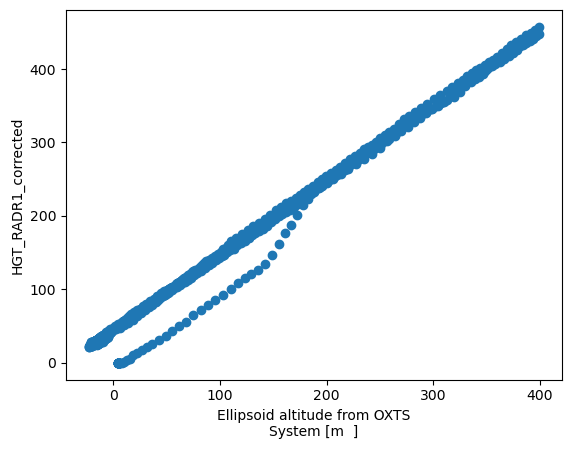

In [102]:
ds_lowlevel = ds.where(ds.ALT_OXTS < 400.0)

fig, ax = plt.subplots()
xr.plot.scatter(ds=ds_lowlevel, x="ALT_OXTS", y="HGT_RADR1_corrected")

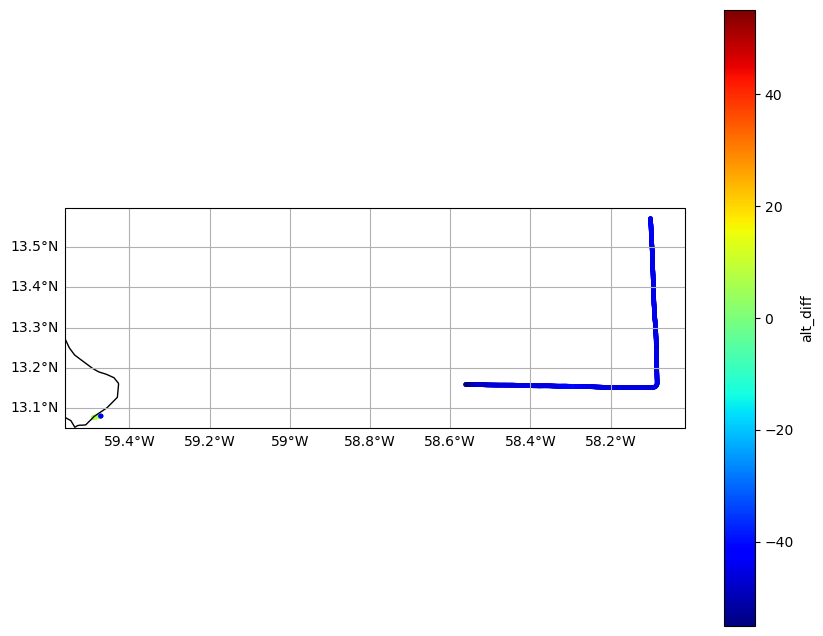

In [118]:
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))

ds["alt_diff"] = ds.ALT_OXTS - ds.HGT_RADR1_corrected
ds_lowlevel = ds.where(ds.ALT_OXTS < 200.0)

xr.plot.scatter(
    ds=ds_lowlevel, x="LON_OXTS", y="LAT_OXTS", hue="alt_diff", cmap="jet", s=5.0
)

ax.gridlines(draw_labels=["left", "bottom"])
ax.coastlines(resolution="10m")

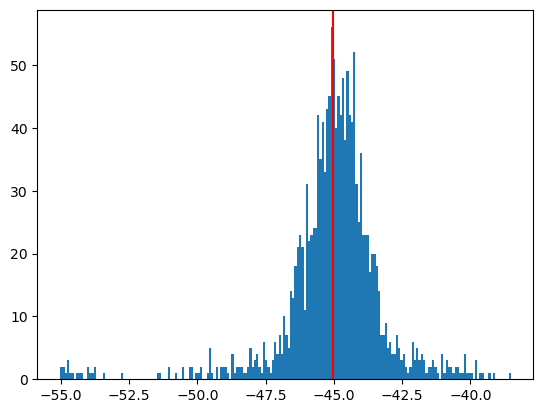

In [122]:
ds_lowlevel_ocean = ds.where(np.logical_and(ds.ALT_OXTS < 200.0, ds.LON_OXTS > -59.4))
da_ocean_offset = (
    ds_lowlevel_ocean.ALT_OXTS - ds_lowlevel_ocean.HGT_RADR1_corrected
).mean()

ds["ALT_OXTS_OFFSET"] = ds.ALT_OXTS - da_ocean_offset
z_threshold = 400
ds["alt_composite"] = ds.HGT_RADR1_corrected.where(
    ds.HGT_RADR1_corrected < z_threshold, ds.ALT_OXTS_OFFSET
)


_ = (ds_lowlevel_ocean.ALT_OXTS - ds_lowlevel_ocean.HGT_RADR1_corrected).plot.hist(
    bins=200
)
plt.gca().axvline(da_ocean_offset, color="red")

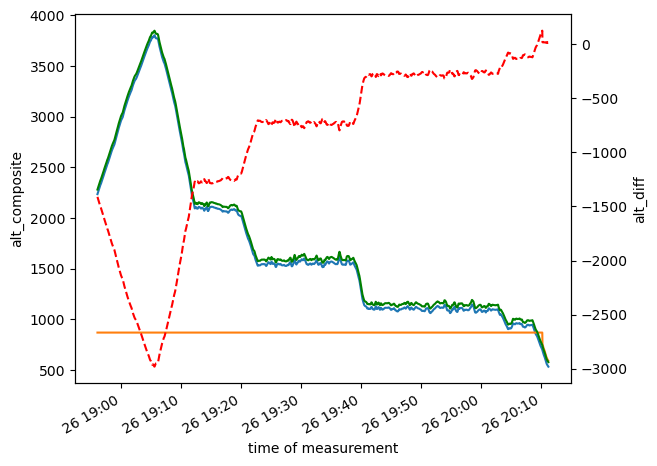

In [120]:
t_interval = (ds.time.max() - np.timedelta64(80, "m"), None)

ds["alt_diff"] = ds.HGT_RADR1_corrected - ds.alt_composite

ds_ = ds.sel(time=slice(*t_interval))
ds_.ALT_OXTS.plot()
ds_.HGT_RADR1_corrected.plot()
ds_.alt_composite.plot(color="green")
plt.gca().twinx()
ds_.alt_diff.plot(color="red", linestyle="--")

Text(0.5, 1.0, 'TO-333')

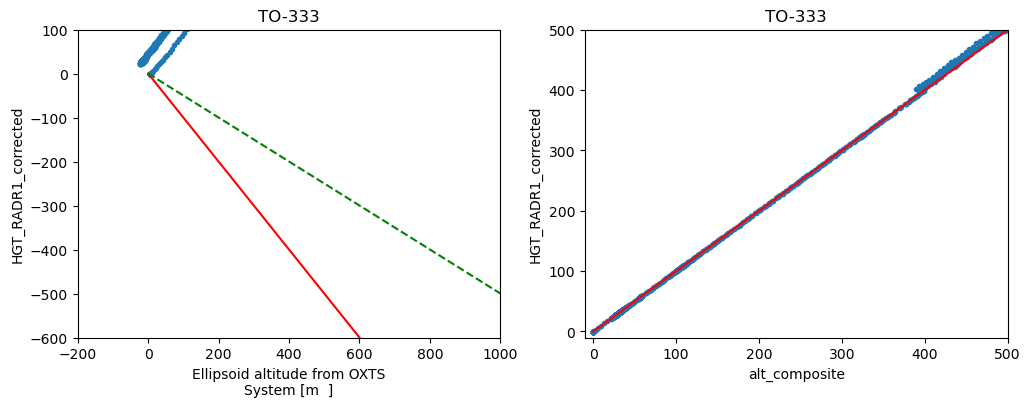

In [121]:
fig, axes = plt.subplots(figsize=(12, 4), ncols=2)

ax = axes[0]
xr.plot.scatter(ds, "ALT_OXTS", "HGT_RADR1_corrected", marker=".", ax=ax)
ax.set_xlim(-200, 1000)
ax.set_ylim(-600, 100)
x = np.linspace(0, 1000, 100)
ax.plot(x, -x, color="red")
ax.plot(x, -0.5 * x, color="green", linestyle="--")
ax.set_title(flight_id)

ax = axes[1]
xr.plot.scatter(ds, "alt_composite", "HGT_RADR1_corrected", marker=".", ax=ax)
ax.set_xlim(-10, 500)
ax.set_ylim(-10, 500)
x = np.linspace(0, 1000, 100)
ax.plot(x, x, color="red")
ax.set_title(flight_id)

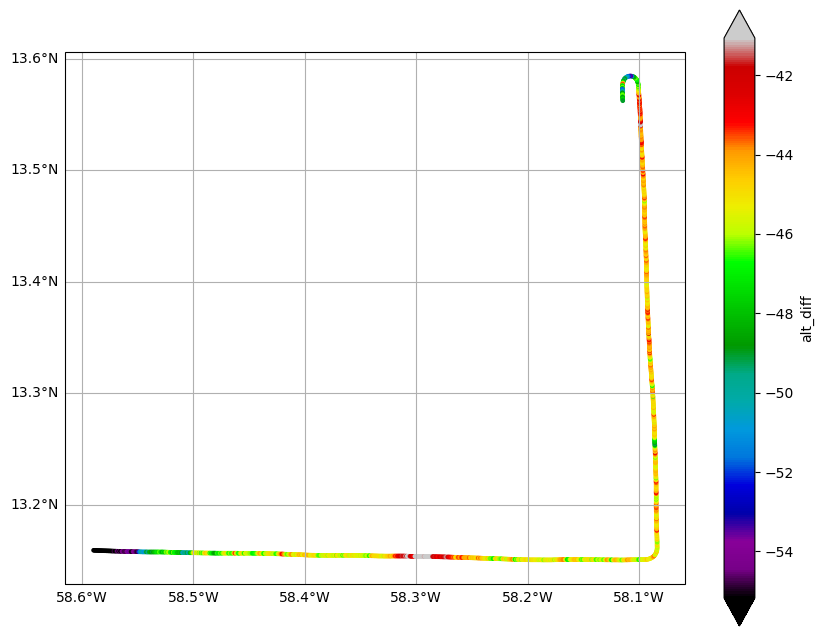

In [98]:
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))


xr.plot.scatter(
    ds=ds_lowlevel_ocean,
    x="LON_OXTS",
    y="LAT_OXTS",
    hue="alt_diff",
    cmap="nipy_spectral",
    s=5.0,
    robust=True,
)

ax.gridlines(draw_labels=["left", "bottom"])
ax.coastlines(resolution="10m")

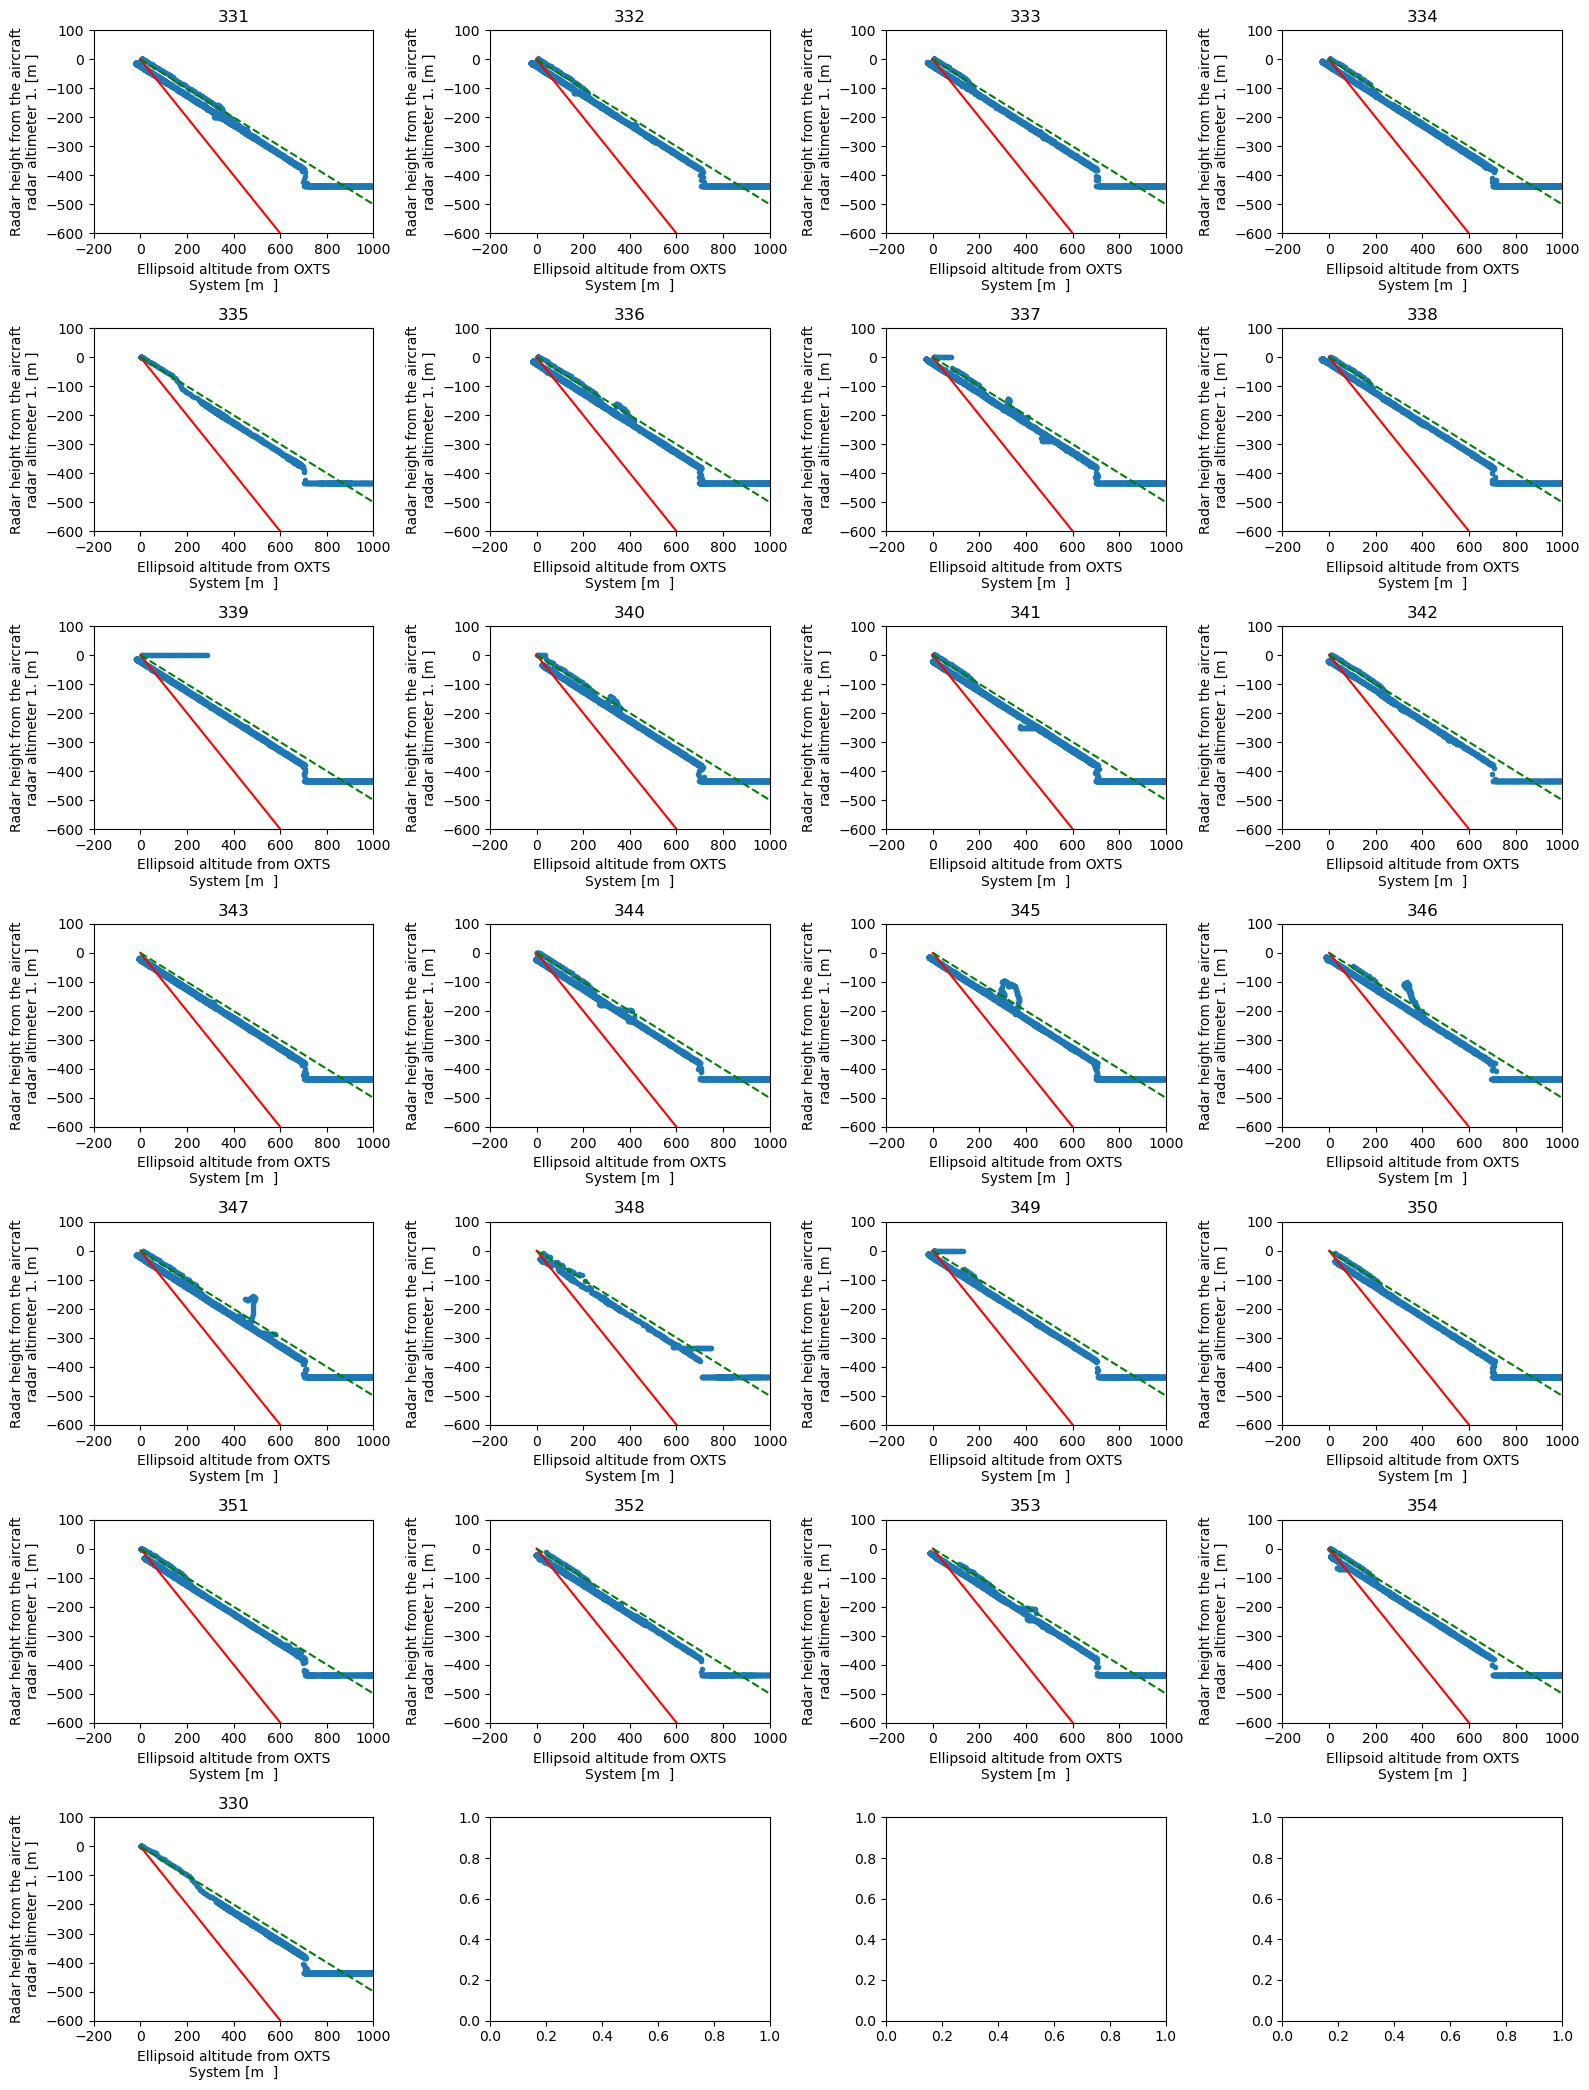

In [22]:
ds_masin = _cache[332]

N_flights = len(_cache)
ncols = 4
nrows = N_flights // ncols
if ncols * nrows < N_flights:
    nrows += 1

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4 * ncols, 3 * nrows))

for ax, (flight_num, ds_masin) in zip(axes.flatten(), _cache.items()):
    

fig.tight_layout()
# ax.set_xlim(0, 200)
# ax.set_ylim(-200, 20)
fig.savefig("MASIN_OXTS_vs_RADAR_alt_comparison.png")

In [26]:
for v in ["ALT_OXTS", "HGT_RADR1", "HGT_RADR2"]:
    print(f"{v}: {ds_masin[v].long_name} [{ds_masin[v].units.strip()}]")

ALT_OXTS: Ellipsoid altitude from OXTS System [m]
HGT_RADR1: Radar height from the aircraft radar altimeter 1. [m]
HGT_RADR2: Radar height from the aircraft radar altimeter 2. [m]


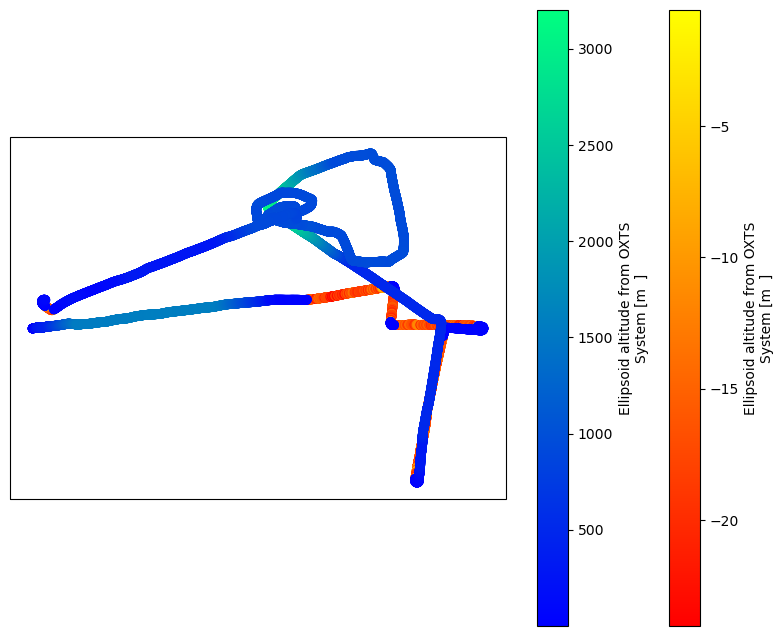

In [14]:
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))

xr.plot.scatter(ds=ds.where(ds.alt < 0.0), x="lon", y="lat", hue="alt", cmap="autumn")
xr.plot.scatter(ds=ds.where(ds.alt > 0.0), x="lon", y="lat", hue="alt", cmap="winter")

# Number of "level" legs

<img src='ATR-segments-dist.png' width=500 />

In [5]:
segment_labels = dict(
    # profile=["profile"],
    boundary_layer=["level", "boundary_layer"],
    cloud=["level", "cloud"],
    cloud_base=["level", "cloud_base"],
    ferry=["level", "transit"],
    flyby_bco=["level", "bco_flyby"],
    cloud_detrainment=["sawtooth", "cloud", "detrainment_layer"],
    # undef_level=["level"],
    coldpool=["level", "cold_pool"],
    above_cloud=["level", "above_cloud"],
    sawtooth=["sawtooth"],
)


def extract_segments(segments_fp):
    flightinfo = yaml.load(
        open(segments_fp),
        Loader=yaml.FullLoader,
    )
    ds_masin = get_navdata_TO(flight_id=flightinfo["flight_id"])
    segment_datasets = []
    for segment in flightinfo["segments"]:
        found_match = False
        for segment_name, segment_kinds in segment_labels.items():
            if set(segment_kinds) == set(segment["kinds"]):
                found_match = True
                ds_masin_segment = ds_masin.sel(
                    time=slice(segment["start"], segment["end"])
                )
                da_segment_alt = ds_masin_segment.alt.mean()
                ds_segment = xr.Dataset(
                    dict(
                        alt=da_segment_alt,
                        name=segment_name.replace("_", " "),
                        flight_id=flightinfo["flight_id"],
                        start=segment["start"],
                        end=segment["end"],
                    ),
                )
                segment_datasets.append(ds_segment)
        if not found_match and segment["kinds"] != ["profile"]:
            print(f"ignoring segment with kinds {segment['kinds']}")

    if len(segment_datasets) == 0:
        raise Exception(f"No matching segments for file {segments_fp}")

    ds_segments = xr.concat(segment_datasets, dim="segment_num")
    return ds_segments

In [6]:
segments_datasets = []
# skip the first flight since it was a calibration flight
segments_fps = sorted(
    list(Path("flight-phase-separation/flight_phase_files/TO/").glob("*.yaml"))
)[1:]

for segments_fp in tqdm(segments_fps):
    ds_segments = extract_segments(segments_fp=segments_fp)
    segments_datasets.append(ds_segments)

  0%|          | 0/24 [00:00<?, ?it/s]

ignoring segment with kinds ['level']
ignoring segment with kinds ['level']
ignoring segment with kinds ['level']
ignoring segment with kinds ['level']
ignoring segment with kinds ['level']
ignoring segment with kinds ['level']
ignoring segment with kinds ['level']
ignoring segment with kinds ['level']
ignoring segment with kinds ['level']
ignoring segment with kinds ['level']
ignoring segment with kinds ['level']
ignoring segment with kinds ['level']
ignoring segment with kinds ['level']
ignoring segment with kinds ['level']
ignoring segment with kinds ['level']
ignoring segment with kinds ['level']
ignoring segment with kinds ['level']
ignoring segment with kinds ['level', 'transit', 'cloud']
ignoring segment with kinds ['calibration', 'level']
ignoring segment with kinds ['calibration', 'level']
ignoring segment with kinds ['calibration', 'level']
ignoring segment with kinds ['level', 'transit', 'cloud']
ignoring segment with kinds ['level', 'boundary layer']
ignoring segment with k

In [7]:
ds_segments = xr.concat(segments_datasets, dim="segment_num").sortby("name")
ds_segments

<xarray.Dataset>
Dimensions:    (segment_num: 234)
Dimensions without coordinates: segment_num
Data variables:
    alt        (segment_num) float32 2.053e+03 2.849e+03 ... 2.962e+03 2.285e+03
    name       (segment_num) <U17 'above cloud' 'above cloud' ... 'sawtooth'
    flight_id  (segment_num) <U7 'TO-0336' 'TO-0340' ... 'TO-0347' 'TO-0351'
    start      (segment_num) datetime64[ns] 2020-01-30T13:23:07 ... 2020-02-1...
    end        (segment_num) datetime64[ns] 2020-01-30T13:28:10 ... 2020-02-1...

Text(0, 0.5, 'number of segments [1]')

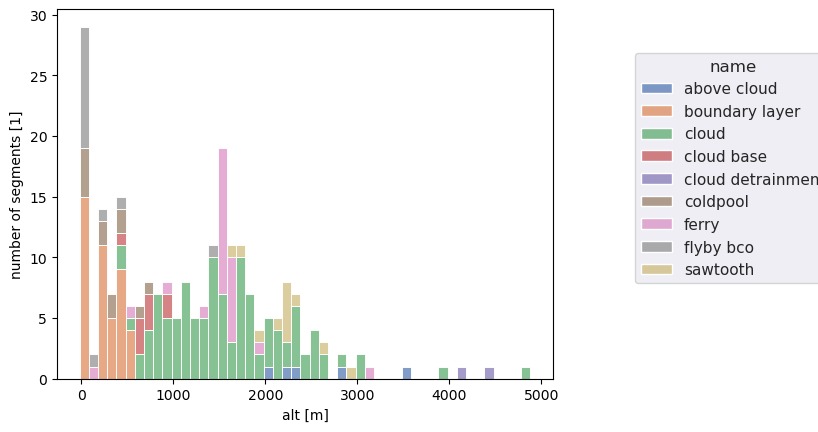

In [8]:
fig, ax = plt.subplots()

(
    so.Plot(ds_segments, x="alt", color="name")
    # .add(so.Bar(), so.Hist(binwidth=500), so.Dodge())
    .add(
        so.Bars(),
        so.Hist(binwidth=100),
        so.Stack()
        # so.Hist(binwidth=500),
    )
    .on(ax)
    .plot()
)
ax.set_xlabel("alt [m]")
ax.set_ylabel("number of segments [1]")

# Flights summary table

<img src="ATR-flights-table.png" width=800 />

In [9]:
flight_numbers = range(330, 354)
flight_stats = dict()
for flight_num in tqdm(flight_numbers):
    flight_id = f"TO-{flight_num:04d}"  # segments use TO-0331 as flight id
    ds_masin = get_navdata_TO(flight_id=flight_id)
    flight_stats[flight_id] = dict(
        date=ds_masin.time.dt.strftime("%d/%m").isel(time=0).item(),
        takeoff=ds_masin.time.dt.strftime("%H:%M").isel(time=0).item(),
        landing=ds_masin.time.dt.strftime("%H:%M").isel(time=-1).item(),
    )

column_units = dict(
    date="Date [DD/MM]",
    takeoff="Takeoff [UTC]",
    landing="Landing [UTC]",
)

  0%|          | 0/24 [00:00<?, ?it/s]

In [14]:
df_flight_stats = pd.DataFrame(flight_stats).transpose()
df_flight_stats.rename(columns=column_units).head()

,Date [DD/MM],Takeoff [UTC],Landing [UTC]
TO-0330,24/01,11:06,14:02
TO-0331,24/01,16:10,19:29
TO-0332,26/01,11:44,15:37
TO-0333,26/01,17:30,20:16
TO-0334,28/01,13:25,17:13


In [15]:
df_segments = ds_segments.to_dataframe()
df_bco_flybys = (
    df_segments[df_segments.name == "flyby bco"]
    .set_index("flight_id")["alt"]
    .rename("BCO flyby")
)
# df_flight_stats = df_flight_stats.join(df_bco_flybys)
# df_flight_stats["BCO flyby"] = df_flight_stats["BCO flyby"].apply(
#    lambda v: np.isnan(v) and " " or f"{v:.0f}m"
# )

In [16]:
def join_alts(df_segments_group):
    return ", ".join(f"{v:.0f}" for v in sorted(df_segments_group.alt)) + " m"


def add_segment_type_summary(
    df_flight_stats, df_segments, segment_name="boundary layer"
):
    df_flight_stats[f"{segment_name}"] = (
        df_segments[df_segments.name == segment_name]
        .groupby("flight_id")
        .apply(join_alts)
    )

    def isnan(v):
        try:
            return np.isnan(v)
        except:
            return False

    df_flight_stats[f"{segment_name}"] = df_flight_stats[f"{segment_name}"].apply(
        lambda v: isnan(v) and " " or v
    )


for segment_name in [
    "ferry",
    "boundary layer",
    "coldpool",
    "cloud base",
    "cloud",
    "flyby bco",
]:
    add_segment_type_summary(
        df_flight_stats=df_flight_stats,
        df_segments=df_segments,
        segment_name=segment_name,
    )
    
    

In [18]:
df_flight_stats.rename(columns=column_units)

,Date [DD/MM],Takeoff [UTC],Landing [UTC],ferry,boundary layer,coldpool,cloud base,cloud,flyby bco
TO-0330,24/01,11:06,14:02,,,,,,
TO-0331,24/01,16:10,19:29,1577 m,,,,"448, 454, 768, 1435, 1487, 1557, 2546, 3888, 4...",4 m
TO-0332,26/01,11:44,15:37,1572 m,"-18, -18, -16, -16, 498, 499 m",,937 m,,278 m
TO-0333,26/01,17:30,20:16,1556 m,"-15, -14, 465, 465 m",,,"940, 1101, 1553, 2089 m",
TO-0334,28/01,13:25,17:13,"903, 1576 m","290, 292 m",,641 m,"974, 1460, 1716, 1792, 1881 m",-7 m
TO-0335,28/01,18:22,22:03,3150 m,,,,"1404, 1708, 1878, 2196 m",
TO-0336,30/01,10:45,14:26,1583 m,"277, 324, 328 m",,,"696, 998, 1091 m",383 m
TO-0337,31/01,13:19,16:55,"1304, 1606 m","255, 257 m",,608 m,"902, 1108, 1683, 1815, 1942 m",1452 m
TO-0338,31/01,18:24,22:30,,,,,,
TO-0339,02/02,11:50,15:31,"1562, 1580 m",264 m,,928 m,"1077, 1389, 1856, 2023, 2513, 2602, 2996 m",-10 m
